# Diagnosing the quality of the posterior generated from SBI
This notebook demonstrates the approach for running this code in the case of SBI being run on the fly, where the {$\theta$,$x$} pairs are generated during the training and again to create the validation set.

This is the use case of SBI presented in mackelab's documentation, where the simulator and prior are passed to the SBI training loop. 

The other option (that our group uses most of the time) is to train and diagnose SBI using a pre-saved training and test dataset of the {$\theta$,$x$} pairs. The notebook example for this is `evaluate_SBI_static.ipynb`.

In [1]:
import sbi
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# remove top and right axis from plots
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

In [2]:
from scripts import evaluate, io

In [3]:
modelloader = io.ModelLoader()
path = "../savedmodels/sbi/"
model_name = "sbi_linear_generative"
posterior = modelloader.load_model_pkl(path, model_name)

../savedmodels/sbi/


In [4]:
def simulator(thetas):#, percent_errors):
    # convert to numpy array (if tensor):
    thetas = np.atleast_2d(thetas)
    # Check if the input has the correct shape
    if thetas.shape[1] != 2:
        raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

    # Unpack the parameters
    if thetas.shape[0] == 1:
        # If there's only one set of parameters, extract them directly
        m, b = thetas[0, 0], thetas[0, 1]
    else:
        # If there are multiple sets of parameters, extract them for each row
        m, b = thetas[:, 0], thetas[:, 1]
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    # Generate random noise (epsilon) based on a normal distribution with mean 0 and standard deviation sigma
    sigma = 5
    ε = rs.normal(loc=0, scale=sigma, size=(len(x), thetas.shape[0]))
    
    # Initialize an empty array to store the results for each set of parameters
    y = np.zeros((len(x), thetas.shape[0]))
    for i in range(thetas.shape[0]):
        m, b = thetas[i, 0], thetas[i, 1]
        y[:, i] = m * x + b + ε[:, i]
    return torch.Tensor(y.T)

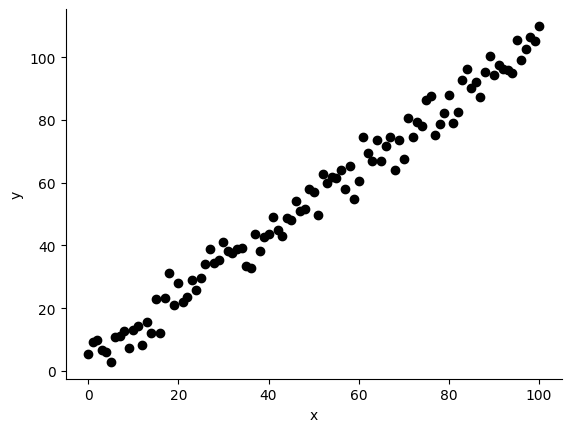

In [5]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            np.array(y_true), color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

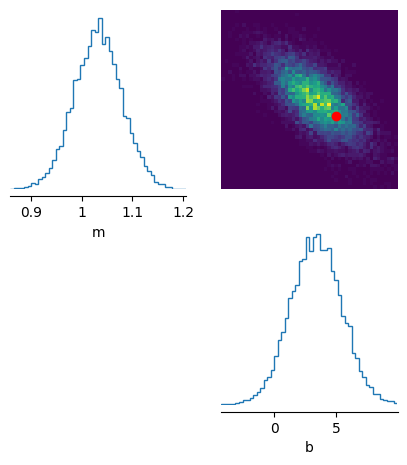

In [6]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)
# that last little part is conditioning on a data value
# plot posterior samples
fig, axes = sbi.analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="red")

# Evaluate posterior by running all-in-one helper function
`run_all_sbc` from the `Diagnose_generative` class.

In [7]:
diagnose_model = evaluate.Diagnose_generative()

In [8]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([8.8201e-30, 1.4518e-27]), 'c2st_ranks': tensor([0.6605, 0.6235]), 'c2st_dap': tensor([0.4765, 0.5110])}


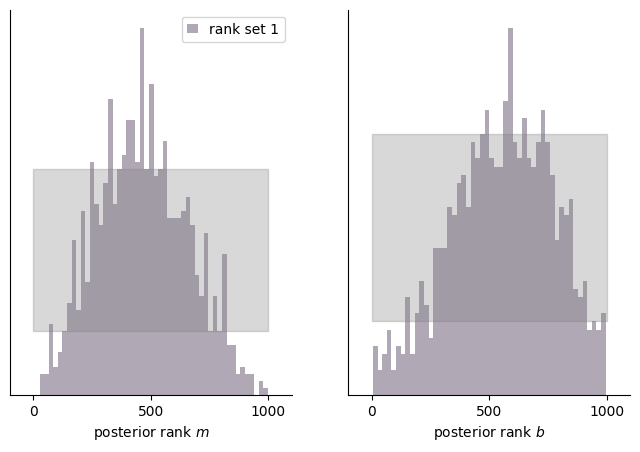

Help on function sbc_rank_plot in module sbi.analysis.plot:

sbc_rank_plot(ranks: Union[torch.Tensor, numpy.ndarray, List[torch.Tensor], List[numpy.ndarray]], num_posterior_samples: int, num_bins: Optional[int] = None, plot_type: str = 'cdf', parameter_labels: Optional[List[str]] = None, ranks_labels: Optional[List[str]] = None, colors: Optional[List[str]] = None, fig: Optional[matplotlib.figure.Figure] = None, ax: Optional[matplotlib.axes._axes.Axes] = None, figsize: Optional[tuple] = None, kwargs: Dict = {}) -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot simulation-based calibration ranks as empirical CDFs or histograms.
    
    Additional options can be passed via the kwargs argument, see _sbc_rank_plot.
    
    Args:
        ranks: Tensor of ranks to be plotted shape (num_sbc_runs, num_parameters), or
            list of Tensors when comparing several sets of ranks, e.g., set of ranks
            obtained from different methods.
        num_bins: number o

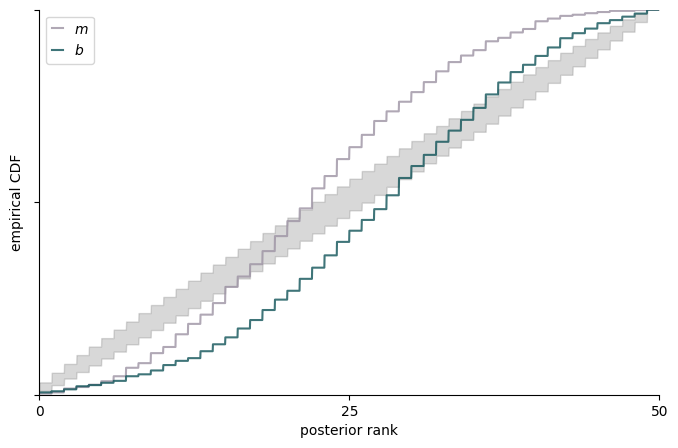

Sampling from the posterior for each obs: 100%|████████████████████████| 1000/1000 [00:13<00:00, 73.38obs/s]


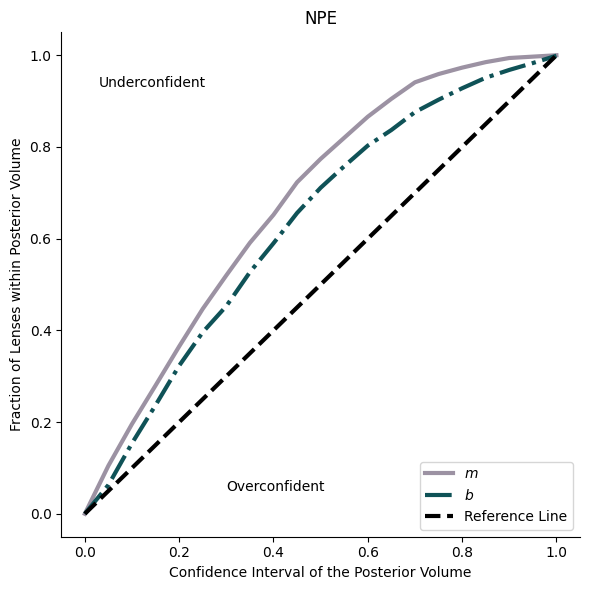

In [9]:
labels_list = ['$m$','$b$']
colorlist = ['#9C92A3','#0F5257']
diagnose_model.run_all_sbc(prior,
                    posterior,
                    simulator,
                    labels_list,
                    colorlist,
                    num_sbc_runs=1_000,
                    num_posterior_samples=1_000,
                    samples_per_inference=1_000,
                    plot=True,
                    save=False,
                    )

# Save to disk

In [ ]:
labels_list = ['$m$','$b$']
colorlist = ['#9C92A3','#0F5257']
diagnose_model.run_all_sbc(prior,
                    posterior,
                    simulator,
                    labels_list,
                    colorlist,
                    num_sbc_runs=1_000,
                    num_posterior_samples=1_000,
                    samples_per_inference=1_000,
                    plot=False,
                    save=True,
                    path='../plots/generative/'
                    )

# Evaluate posterior by running individual pieces
Let's say you just want to get the statistics from the rank plots and print them under the rank plots.


In [ ]:
diagnose_model = evaluate.Diagnose_on_the_fly_data_generation()

In [ ]:
num_sbc_runs = 1_000
num_posterior_samples = 1_000
thetas, ys, ranks, dap_samples = diagnose_model.generate_sbc_samples(prior,
                                                                     posterior,
                                                                     simulator,
                                                                     num_sbc_runs,
                                                                     num_posterior_samples)

diagnose_model.plot_1d_ranks(ranks,
              num_posterior_samples,
              labels_list,
              colorlist,
              plot=True,
              save=False)

In [ ]:
stats = diagnose_model.sbc_statistics(ranks,
                            thetas,
                            dap_samples,
                            num_posterior_samples)
print(stats)